# Sentiment Analysis for Tweets about US Airlines

## About the data

The data is the Twitter US Airline Sentiment from 2015 on Kaggle. For more info, visit the [dataset](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment).

In [292]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from nltk.tokenize import word_tokenize

## Load in the dataset

In [293]:
df = pd.read_csv("Tweets.csv", usecols=[1, 2, 3, 4, 5, 9, 10, 13])

In [294]:
# Note: The info here is run AFTER filling up NaN and converting to numbers
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             14640 non-null  object 
 1   airline_sentiment_confidence  14640 non-null  float64
 2   negativereason                9178 non-null   object 
 3   negativereason_confidence     10522 non-null  float64
 4   airline                       14640 non-null  object 
 5   retweet_count                 14640 non-null  int64  
 6   text                          14640 non-null  object 
 7   tweet_location                9907 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 915.1+ KB


### Fill in the missing data

In [295]:
df['negativereason'] = df['negativereason'].fillna("Unknown")
df['negativereason_confidence'] = df['negativereason_confidence'].fillna(0)
df['tweet_location'] = df['tweet_location'].fillna("Unknown")

In [296]:
# Convert some fields into numbers
df['airline_sentiment'] = df['airline_sentiment'].map({"neutral": 0, "positive": 1, "negative": 2})

# Here, it's safe to assume that negative reason is like a field in some survey (with predetermined values)
# So I can fit the encoder to the entire dataset. (without the worry of leaking data)
neg_reason_encoder = LabelEncoder()
df['negativereason'] = neg_reason_encoder.fit_transform(df['negativereason'])

### Split the dataset

In [297]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [298]:
# Normalize large numerical fields
retweet_scalar = StandardScaler()
df_train['retweet_count'] = retweet_scalar.fit_transform(df_train['retweet_count'].to_frame())
df_test['retweet_count'] = retweet_scalar.transform(df_test['retweet_count'].to_frame())

### Build the vocabulary and embedding mapping for location

In [299]:
token2int = {"<pad>": 0, "<unk>": 1}
text_train = []
i = 2
for obs in df_train['text']:
    tokens = word_tokenize(obs)
    for token in tokens:
        if token2int.setdefault(token, i) == i:
            i += 1
    text_train.append([token2int[token] for token in tokens])

In [300]:
text_test = []
for obs in df_test['text']:
    tokens = word_tokenize(obs)
    cmt = []
    for token in tokens:
        cmt.append(token2int[token] if token in token2int else token2int["<unk>"])
    text_test.append(cmt)

In [301]:
text_train[0]

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [302]:
location2int = {"<unk>": 0}
i = 1
for obs in df_train['tweet_location']:
    if location2int.setdefault(obs, i) == i:
        i += 1
last_i = i + 1

In [303]:
airline2int = {"<unk>": 0}
i = 1
for obs in df_train['airline']:
    if airline2int.setdefault(obs, i) == i:
        i += 1
last_i = i + 1

#### Convert the data frame to arrays/lists for use 

In [304]:
# Convert the texts and locations to indices
location_train = df_train['tweet_location'].map(location2int).to_numpy().reshape(-1, 1)
location_test = df_test['tweet_location'].map(location2int).fillna(last_i).to_numpy().reshape(-1, 1)

In [305]:
# Convert the texts and locations to indices
airline_train = df_train['airline'].map(airline2int).to_numpy().reshape(-1, 1)
airline_test = df_test['airline'].map(airline2int).fillna(last_i).to_numpy().reshape(-1, 1)

In [306]:
numerical_train = df_train[['airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 
                            "retweet_count"]].to_numpy().reshape(len(df_train), -1)

numerical_test = df_test[['airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 
                            "retweet_count"]].to_numpy().reshape(len(df_test), -1)

In [307]:
len(token2int), len(location2int), len(airline2int), len(text_train), len(text_train[0]), numerical_test.shape, location_train.shape

(17357, 2742, 7, 11712, 9, (2928, 4), (11712, 1))

In [308]:
labels_train = df_train['airline_sentiment'].to_numpy()
labels_test = df_test['airline_sentiment'].to_numpy()
labels_train.shape, labels_test.shape

((11712,), (2928,))

### Data Module for storing data

In [309]:
class SentimentDataset():
    def __init__(self, text: list[list], location: np.ndarray, airline: np.ndarray, numerical: np.ndarray, labels: np.ndarray):
        self.text = text
        self.location = location
        self.airline = airline
        self.numerical = numerical
        self.labels = labels
    
    def generator(self, batch_size=32):
        text, location, airline, numerical, labels = shuffle(self.text, self.location, self.airline, self.numerical, self.labels)
        assert len(text) == len(location) == len(numerical) == len(labels) == len(airline)
        num_batches = int(np.ceil(len(numerical) / batch_size))
        for idx in range(num_batches):
            # Grab a batch
            end = min((idx + 1) * batch_size, len(numerical))
            text_batch = text[idx * batch_size: end]
            location_batch = location[idx * batch_size: end]
            airline_batch = airline[idx * batch_size: end]
            numerical_batch = numerical[idx * batch_size: end]
            labels_batch = labels[idx * batch_size: end]
            
            # Pad the text vector
            #! Empty iterator
            max_len = max([len(cmt) for cmt in text_batch])
            for j in range(len(text_batch)):
                text_batch[j] = [token2int["<pad>"]] * (max_len - len(text_batch[j])) + text_batch[j]
            
            # Convert to torch Tensors
            text_batch = torch.from_numpy(np.array(text_batch).astype(np.float32)).long()
            location_batch = torch.from_numpy(location_batch.astype(np.float32)).long()
            airline_batch = torch.from_numpy(airline_batch.astype(np.float32)).long()
            numerical_batch = torch.from_numpy(numerical_batch.astype(np.float32))
            labels_batch = torch.from_numpy(labels_batch.astype(np.float32)).long()
            
            yield text_batch, location_batch, airline_batch, numerical_batch, labels_batch

In [310]:
train_dataset = SentimentDataset(text_train, location_train, airline_train, numerical_train, labels_train)
test_dataset = SentimentDataset(text_test, location_test, airline_test, numerical_test, labels_test)

## Build the model

The key here is to embed the text and location fields, concatenate them, pass them through the RNN layers, then combine them with the numerical data as input to the linear layers. 

In [311]:
class Sentiment_RNN(nn.Module):
    def __init__(self, numer_feats, vocab_size, num_locations, num_airlines, embed_dim, embed_loc, embed_airl,
                    num_outs, num_hiddens, num_layers, device: torch.device):
        super(Sentiment_RNN, self).__init__()
        
        # For convenient use
        self.L = num_layers
        self.V1 = vocab_size
        self.E1 = embed_dim
        self.V2 = num_locations
        self.E2 = embed_loc
        self.V3 = num_locations
        self.E3 = embed_loc
        self.M1 = num_hiddens
        self.M2 = numer_feats  # Number of numerical features
        self.K = num_outs
        self._device = device
        
        # Embedding layers
        self.embed_text = nn.Embedding(self.V1, self.E1)
        self.embed_location = nn.Embedding(self.V2, self.E2)
        self.embed_airline = nn.Embedding(self.V3, self.E3)
        
        # RNN layers
        self.rnn = nn.LSTM(
            input_size=self.E1,
            hidden_size=self.M1,
            num_layers=self.L,
            batch_first=True,
        )
        
        # Linear layer
        self.fc = nn.Sequential(
            nn.Linear(self.M1 + self.E2 + self.M2 + self.E3, self.K)
        )
        
    def forward(self, X):
        # Break the data into parts
        text, location, airline, numerical = X
        
        # Hidden initial states and cells for RNN
        h0 = torch.zeros(self.L, text.size(0), self.M1).to(self._device)
        c0 = torch.zeros(self.L, text.size(0), self.M1).to(self._device)
        
        # Embed the text, location, and airline
        text_embed = self.embed_text(text)
        location_embed = self.embed_location(location).reshape(location.size(0), self.E2)
        airline_embed = self.embed_location(airline).reshape(airline.size(0), self.E3)
        
        # RNN layers (output of shape N x L x M1)
        text_out, _ = self.rnn(text_embed, (h0, c0))
        
        # Concatenate the tensors (along the same observation)
        out = torch.concat((text_out[:, -1, :], location_embed, airline_embed, numerical), dim=1)
        
        # Dense layer
        out = self.fc(out)
        return out

In [312]:
def configure(model, device, lr, optim_med):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer: optim.Optimizer
    if optim_med == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99)
    return criterion, optimizer

In [313]:
def batch_gd(model, criterion, optimizer, device, train_dataset, test_dataset, num_epochs):
    loss_his, test_his = np.zeros(num_epochs), np.zeros(num_epochs)
    for epoch in range(num_epochs):
        # Train
        train_losses = []
        for *inputs, labels in train_dataset.generator():
            # Zero the gradient
            optimizer.zero_grad()
            
            # Move data to device
            inputs = (vec.to(device) for vec in inputs)
            labels = labels.to(device)
            
            # Forward pass
            outs = model(inputs)
            train_loss = criterion(outs, labels)
            train_losses.append(train_loss.item())
            
            # Update the parameters
            train_loss.backward()
            optimizer.step()
        
        loss_his[epoch] = np.mean(train_losses)

        # Validate
        test_losses = []
        for *inputs, labels in test_dataset.generator():
            # Move data to device
            inputs = (vec.to(device) for vec in inputs)
            labels = labels.to(device)
            
            # Forward pass
            outs = model(inputs)
            test_loss = criterion(outs, labels)
            test_losses.append(test_loss.item())
        
        test_his[epoch] = np.mean(test_losses)
    
    return loss_his, test_his

### Train the model

In [324]:
# Hyperparameters
embed_dim, embed_loc, embed_airl = 20, 5, 5 
num_hiddens, num_layers = 20, 3
lr = 0.01
optim_med = 'adam'
num_epochs = 50

# Setting the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [325]:
# Initiate the model and configure
model = Sentiment_RNN(numer_feats=4, vocab_size=len(token2int), num_locations=len(location2int), num_airlines=len(airline2int),
                        embed_dim=embed_dim, embed_loc=embed_loc, embed_airl=embed_airl, num_outs=3,
                        num_hiddens=num_hiddens, num_layers=num_layers, device=device)
criterion, optimizer = configure(model, device, lr, optim_med)

In [326]:
from time import perf_counter

In [327]:
# Train the model
start = perf_counter()
loss_his, test_his = batch_gd(model, criterion, optimizer, device, train_dataset, test_dataset, num_epochs)
end = perf_counter()
f"{end-start:.2f}s needed!"

'173.51s needed!'

### Evaluate the model

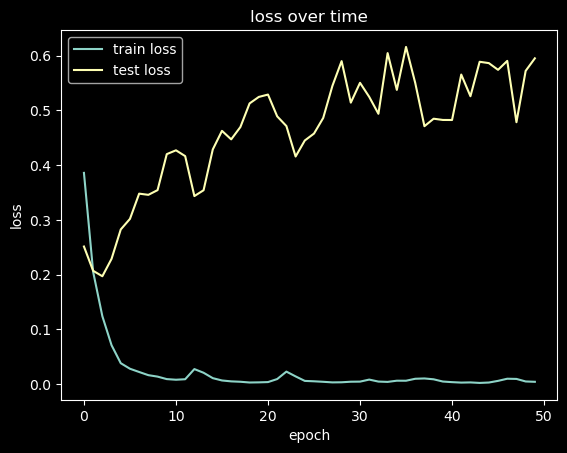

In [328]:
plt.title("loss over time")
plt.plot(loss_his, label="train loss")
plt.plot(test_his, label="test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

#### Compute the accuracy

In [329]:
def compute_acc(model, dataset, device):
    n_correct, n_total = 0, 0
    for *inputs, labels in dataset.generator():
        # Move the data to device
        inputs = (vec.to(device) for vec in inputs)
        labels = labels.to(device)
        
        # Forward pass
        outs = model(inputs).detach()
        _, preds = torch.max(outs, 1)

        n_correct += (preds == labels).cpu().sum().item()
        n_total += labels.size(0)
    
    return n_correct / n_total

In [330]:
f"Train accuracy={compute_acc(model, train_dataset, device)}; Test accuracy={compute_acc(model, test_dataset, device)}"

'Train accuracy=0.9986338797814208; Test accuracy=0.9146174863387978'